In [1]:
# Import basic packages lik numpy, pandas, math plot and seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick # For specifying the axes tick format 
%matplotlib inline
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, roc_curve, precision_recall_curve, accuracy_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.svm import SVC
import plotly.tools as tls
import plotly.offline as py
from datetime import datetime
import lightgbm as lgbm
import warnings
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
py.init_notebook_mode(connected=True)
import plotly.figure_factory as ff 
from contextlib import contextmanager

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

warnings.filterwarnings('ignore') #ignore warning messages 

In [2]:
# import dataset
df = pd.read_csv('https://raw.githubusercontent.com/lijjumathew/MSDS-Machine-Learning-1-Project/master/dataset/Telco-Customer-Churn.csv')

In [3]:
#Ideally SeniorCitizen column should be a factor, so let's convert 1,0 values to Yes,No and later we can label encode all factor columns
df.SeniorCitizen=df.SeniorCitizen.apply(lambda x: 'Yes' if x==1 else 'No')

# Getting rid of unwanted columns like Customer Id.
if 'customerID' in df:
    del df['customerID']
    
# converting TotalCharges object dataset into numeric
# errors = 'coerce’ means, if invalid parsing occur then set NaN
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors = 'coerce')

# Replacing blank values with nulls.
df=df.replace(r'^\s*$', np.nan, regex=True)

# Total charges has some blank values/missing values and needs to be imputed. Filling the missing values
df["TotalCharges"].fillna(df["TotalCharges"].mean(), inplace=True)

# Consolidate MultipleLines attribute
df['MultipleLines'] = df['MultipleLines'].replace('No phone service','No')

# Change all values of 'No internet service' to 'No'
df = df.replace('No internet service','No')

# Replace all yes/no values with 1/0
df = df.replace(to_replace=['Yes','No'], value=[1,0])

# Create dummy variables in the entire dataset
df = pd.get_dummies(df)

In [4]:
# Separate the churn results from the dataset
y = df['Churn'].values
x = df.drop(columns = ['Churn'])

# Set features
features = x.columns.values

# Normalize values
# It is important to scale the variables in logistic regression so that all of them are within a range of 0 to 1. They can imporve accuracy
scale = MinMaxScaler(feature_range = (0,1))
scale.fit(x)
x = pd.DataFrame(scale.transform(x))
x.columns = features

In [5]:
# Set up train/test split with 80/20 ratio
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 99)

# Create the model and fit
model = LogisticRegression()
fit = model.fit(x_train,y_train)
predict = model.predict(x_test)
score = model.predict_proba(x_test)[:,1]
print("Our accuracy score of the model using logistic regression is: ",metrics.accuracy_score(y_test,predict))
print(classification_report(y_test,predict))

Our accuracy score of the model using logistic regression is:  0.7998580553584103
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1023
           1       0.67      0.54      0.60       386

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409



# Getting the Accuracy, Confusion Matrix, ROC Curve, ROC-AUC score and TPR/FPR rate also called as Specificity & Sensitivity
Accuracy is calculated on the test data set
Confusion Matrix tells us how many True Positive/True Negatives and False Positives/False Negatives are present in the prediction
 - TP: # of customers who will actually default also predicted as default
 - TN: # of customers who won't actually default also predicted as no default
 - FP: # of customers who won't actually default but predicted as default
 - FN: # of customers who will actually default but predicted as no default
 
ROC curve is a plot between Sensitivity and Specificity predictions for all the different thresholds
ROC-AUC score - It is the area under the ROC curve. It helps us compare different models. 

Higher AUC implies a better model.
Below is the function to print acuracy score, ROC curvey, ROC-AUC score and confusion matrix

In [6]:
def model_performance(model) : 
    #Conf matrix
    conf_matrix = confusion_matrix(y_test, predict)
    trace1 = go.Heatmap(z = conf_matrix  ,x = ["0 (pred)","1 (pred)"],
                        y = ["0 (true)","1 (true)"],xgap = 2, ygap = 2, 
                        colorscale = 'Viridis', showscale  = False)

    #Show metrics
    tp = conf_matrix[1,1]
    fn = conf_matrix[1,0]
    fp = conf_matrix[0,1]
    tn = conf_matrix[0,0]
    Accuracy  =  ((tp+tn)/(tp+tn+fp+fn))
    Precision =  (tp/(tp+fp))
    Recall    =  (tp/(tp+fn))
    F1_score  =  (2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))))

    show_metrics = pd.DataFrame(data=[[Accuracy , Precision, Recall, F1_score]])
    show_metrics = show_metrics.T

    colors = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue']
    trace2 = go.Bar(x = (show_metrics[0].values), 
                    y = ['Accuracy', 'Precision', 'Recall', 'F1_score'], text = np.round_(show_metrics[0].values,4),
                    textposition = 'auto', textfont=dict(color='black'),
                    orientation = 'h', opacity = 1, marker=dict(
            color=colors,
            line=dict(color='#000000',width=1.5)))
    
    #Roc curve
    model_roc_auc = round(roc_auc_score(y_test, score) , 3)
    fpr, tpr, t = roc_curve(y_test, score)
    trace3 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2), fill='tozeroy')
    trace4 = go.Scatter(x = [0,1],y = [0,1],
                        line = dict(color = ('black'),width = 1.5,
                        dash = 'dot'))
    
    # Precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, score)
    trace5 = go.Scatter(x = recall, y = precision,
                        name = "Precision" + str(precision),
                        line = dict(color = ('lightcoral'),width = 2), fill='tozeroy')
    
#     #Feature importance
#     coefficients  = pd.DataFrame(eval(model).feature_importances_)
#     column_data   = pd.DataFrame(list(data))
#     coef_sumry    = (pd.merge(coefficients,column_data,left_index= True,
#                               right_index= True, how = "left"))
#     coef_sumry.columns = ["coefficients","features"]
#     coef_sumry    = coef_sumry.sort_values(by = "coefficients",ascending = False)
#     coef_sumry = coef_sumry[coef_sumry["coefficients"] !=0]
#     trace6 = go.Bar(x = coef_sumry["features"],y = coef_sumry["coefficients"],
#                     name = "coefficients", 
#                     marker = dict(color = coef_sumry["coefficients"],
#                                   colorscale = "Viridis",
#                                   line = dict(width = .6,color = "black")))
    
    #Cumulative gain
    pos = pd.get_dummies(y_test).to_numpy()
    pos = pos[:,1] 
    npos = np.sum(pos)
    index = np.argsort(score) 
    index = index[::-1] 
    sort_pos = pos[index]
    #cumulative sum
    cpos = np.cumsum(sort_pos) 
    #recall
    recall = cpos/npos 
    #size obs test
    n = y_test.shape[0] 
    size = np.arange(start=1,stop=369,step=1) 
    #proportion
    size = size / n 
    #plots
    model = model
    trace7 = go.Scatter(x = size,y = recall,
                        line = dict(color = ('gold'),width = 2), fill='tozeroy') 
    
    #Subplots
    fig = tls.make_subplots(rows=3, cols=2, print_grid=False,
                          specs=[[{}, {}], 
                                 [{}, {}],
                                 [{'colspan': 2}, None]],
                          subplot_titles=('Confusion Matrix',
                                          'Metrics',
                                          'ROC curve'+" "+ '('+ str(model_roc_auc)+')',
                                          'Precision - Recall curve',
                                          'Cumulative gains curve'
                                          ))
    
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,2,1)
    fig.append_trace(trace4,2,1)
    fig.append_trace(trace5,2,2)
    #fig.append_trace(trace6,4,1)
    fig.append_trace(trace7,3,1)
    
    fig['layout'].update(showlegend = False, title = '<b>Model performance report</b><br>'+str(model),
                        autosize = False, height = 1500,width = 830,
                        plot_bgcolor = 'black',
                        paper_bgcolor = 'black',
                        margin = dict(b = 195), font=dict(color='white'))
    fig["layout"]["xaxis1"].update(color = 'white')
    fig["layout"]["yaxis1"].update(color = 'white')
    fig["layout"]["xaxis2"].update((dict(range=[0, 1], color = 'white')))
    fig["layout"]["yaxis2"].update(color = 'white')
    fig["layout"]["xaxis3"].update(dict(title = "false positive rate"), color = 'white')
    fig["layout"]["yaxis3"].update(dict(title = "true positive rate"),color = 'white')
    fig["layout"]["xaxis4"].update(dict(title = "recall"), range = [0,1.05],color = 'white')
    fig["layout"]["yaxis4"].update(dict(title = "precision"), range = [0,1.05],color = 'white')
    fig["layout"]["xaxis5"].update(dict(title = "Percentage contacted"),color = 'white')
    fig["layout"]["yaxis5"].update(dict(title = "Percentage positive targeted"),color = 'white')
    #fig["layout"]["xaxis6"].update(color = 'white')
    #fig["layout"]["yaxis6"].update(color = 'white')
    for i in fig['layout']['annotations']:
        i['font'] = titlefont=dict(color='white', size = 14)
    py.iplot(fig)
    

In [7]:
model_performance(model)

In [8]:
# Calculate and display weights from logistic regression
weights = pd.Series(model.coef_[0], index=x.columns.values)
print(weights.sort_values(ascending = False))

TotalCharges                               0.987158
InternetService_Fiber optic                0.822797
Contract_Month-to-month                    0.698867
PaperlessBilling                           0.371334
PaymentMethod_Electronic check             0.292634
MultipleLines                              0.240501
SeniorCitizen                              0.233807
StreamingTV                                0.181166
StreamingMovies                            0.180732
gender_Female                              0.016114
InternetService_DSL                        0.014568
Contract_One year                          0.007922
MonthlyCharges                             0.000814
gender_Male                               -0.015306
PaymentMethod_Mailed check                -0.020221
DeviceProtection                          -0.023484
Partner                                   -0.056451
PaymentMethod_Credit card (automatic)     -0.118700
Dependents                                -0.131897
OnlineBackup

In [9]:
from sklearn.preprocessing import StandardScaler

# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(x_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

x_train_scaled = scl_obj.transform(x_train) # apply to training
x_test_scaled = scl_obj.transform(x_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
lr_clf = LogisticRegression(penalty='l2', C=0.05, solver='liblinear') # get object, the 'C' value is less (can you guess why??)
lr_clf.fit(x_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(x_test_scaled) # get test set precitions

acc = metrics.accuracy_score(y_test,y_hat)
conf = metrics.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )

# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,df.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

accuracy: 0.7970191625266146
[[917 106]
 [180 206]]
tenure has weight of -0.7827311937436199
gender_Male has weight of -0.32070095610618543
Contract_One year has weight of -0.28773904658151106
OnlineSecurity has weight of -0.1958241896445182
TechSupport has weight of -0.14652320642901462
PhoneService has weight of -0.13398740382899915
Contract_Two year has weight of -0.07215701589537192
OnlineBackup has weight of -0.07200490850248643
Dependents has weight of -0.05994537197821957
PaymentMethod_Bank transfer (automatic) has weight of -0.05805321342249012
Contract_Month-to-month has weight of -0.04554570180008888
InternetService_0 has weight of -0.039620713048057914
Partner has weight of -0.030930329684588604
DeviceProtection has weight of -0.020756366654210413
PaymentMethod_Electronic check has weight of -0.017051146972409954
gender_Female has weight of -0.007851641497605106
Churn has weight of 0.007851641497605422
StreamingMovies has weight of 0.06950857432974661
StreamingTV has weight 

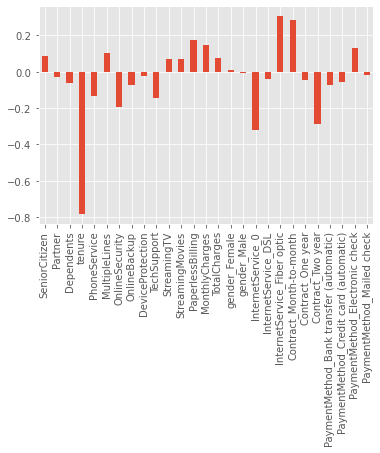

In [10]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


weights = pd.Series(lr_clf.coef_[0],index=x.columns.values)
weights.plot(kind='bar')
plt.show()

AxesSubplot(0.125,0.125;0.775x0.755)


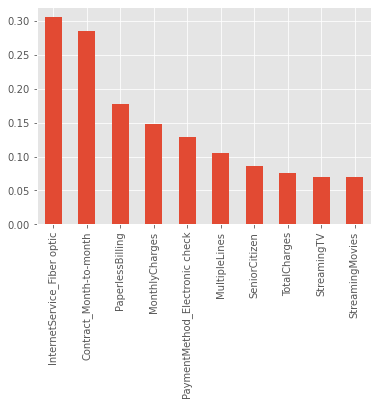

In [11]:
# To get the weights of all the variables
weights = pd.Series(lr_clf.coef_[0],
                 index=x.columns.values)
print (weights.sort_values(ascending = False)[:10].plot(kind='bar'))

AxesSubplot(0.125,0.125;0.775x0.755)


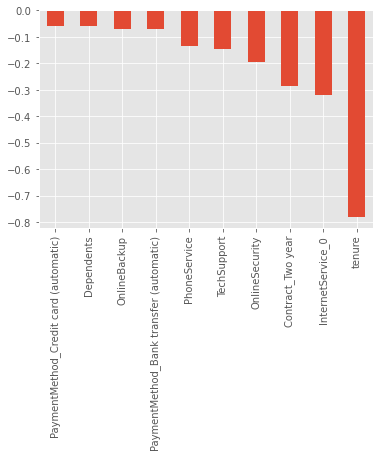

In [12]:
print(weights.sort_values(ascending = False)[-10:].plot(kind='bar'))


# Observations

We can see that some variables have a negative relation to our predicted variable (Churn), while some have positive relation. Negative relation means that likeliness of churn decreases with that variable. Let us summarize some of the interesting features below:

As we saw in our EDA, having a monthly contract reduces chances of churn. monthly contract along with tenure have the most negative relation with Churn as predicted by logistic regressions Having DSL internet service also reduces the proability of Churn Lastly, total charges, monthly contracts, fibre optic internet services and seniority can lead to higher churn rates. This is interesting because although fibre optic services are faster, customers are likely to churn because of it. I think we need to explore more to better understad why this is happening. Any hypothesis on the above would be really helpful!

In [13]:
# Fit and predict using SVM
# Support Vectors are the data points that are closest to the edges of the margin of the separating line.
# The separating line and margins are called the hyperplane
svm = SVC(kernel='rbf',cache_size=1000)
svm.fit(x_train,y_train)
predict = svm.predict(x_test)
print("Our accuracy score of the model using SVM is: ",metrics.accuracy_score(y_test,predict))
print("This is about the same as our logistic regression model")

Our accuracy score of the model using SVM is:  0.7955997161107168
This is about the same as our logistic regression model


In [14]:
# Confusion matrix
print(confusion_matrix(y_test,predict))

[[930  93]
 [195 191]]


In [15]:
model_performance(svm)

# Observations
With SVM we get accuracy of up to 79%